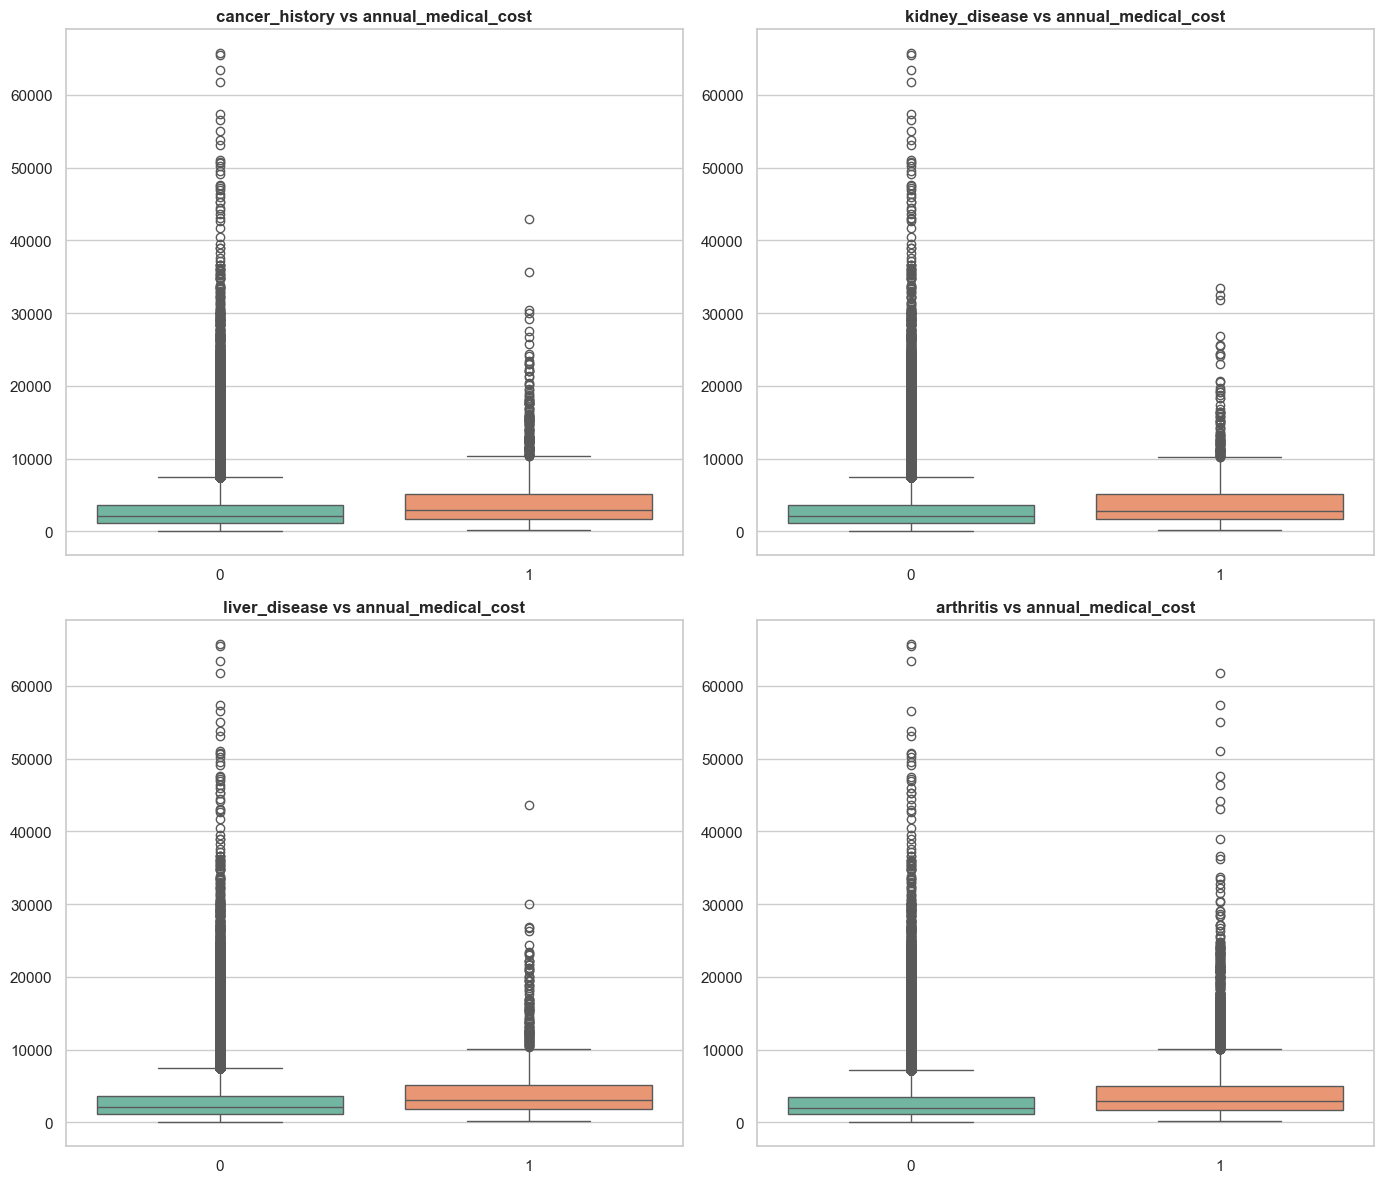

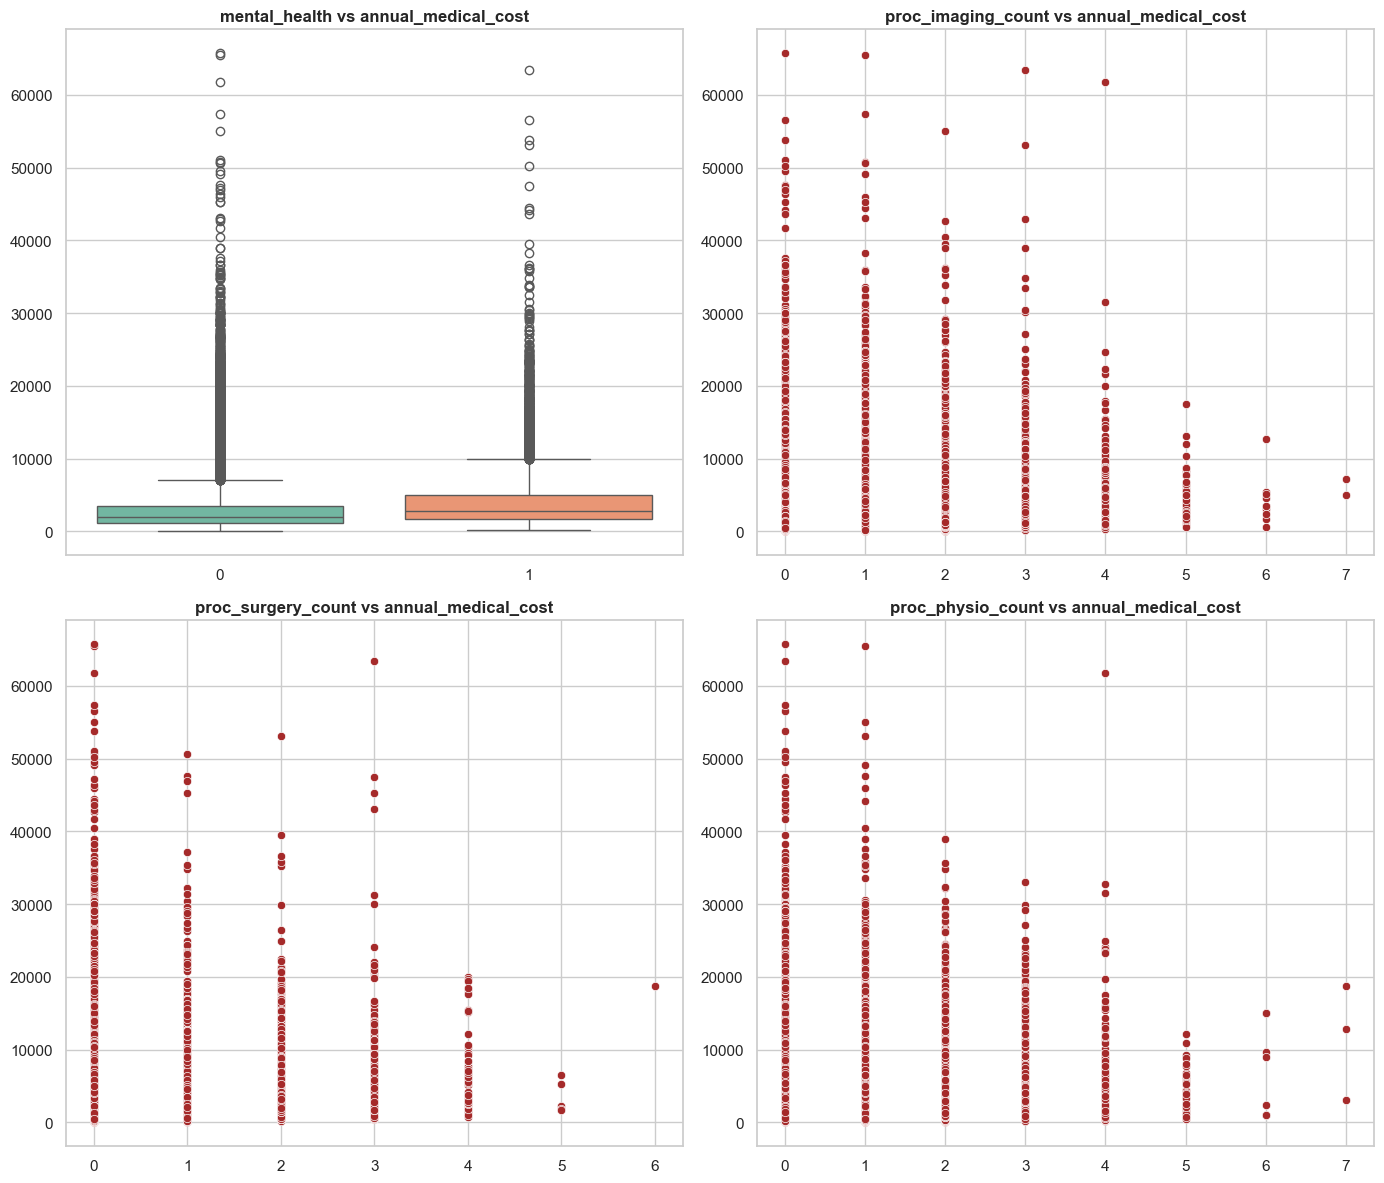

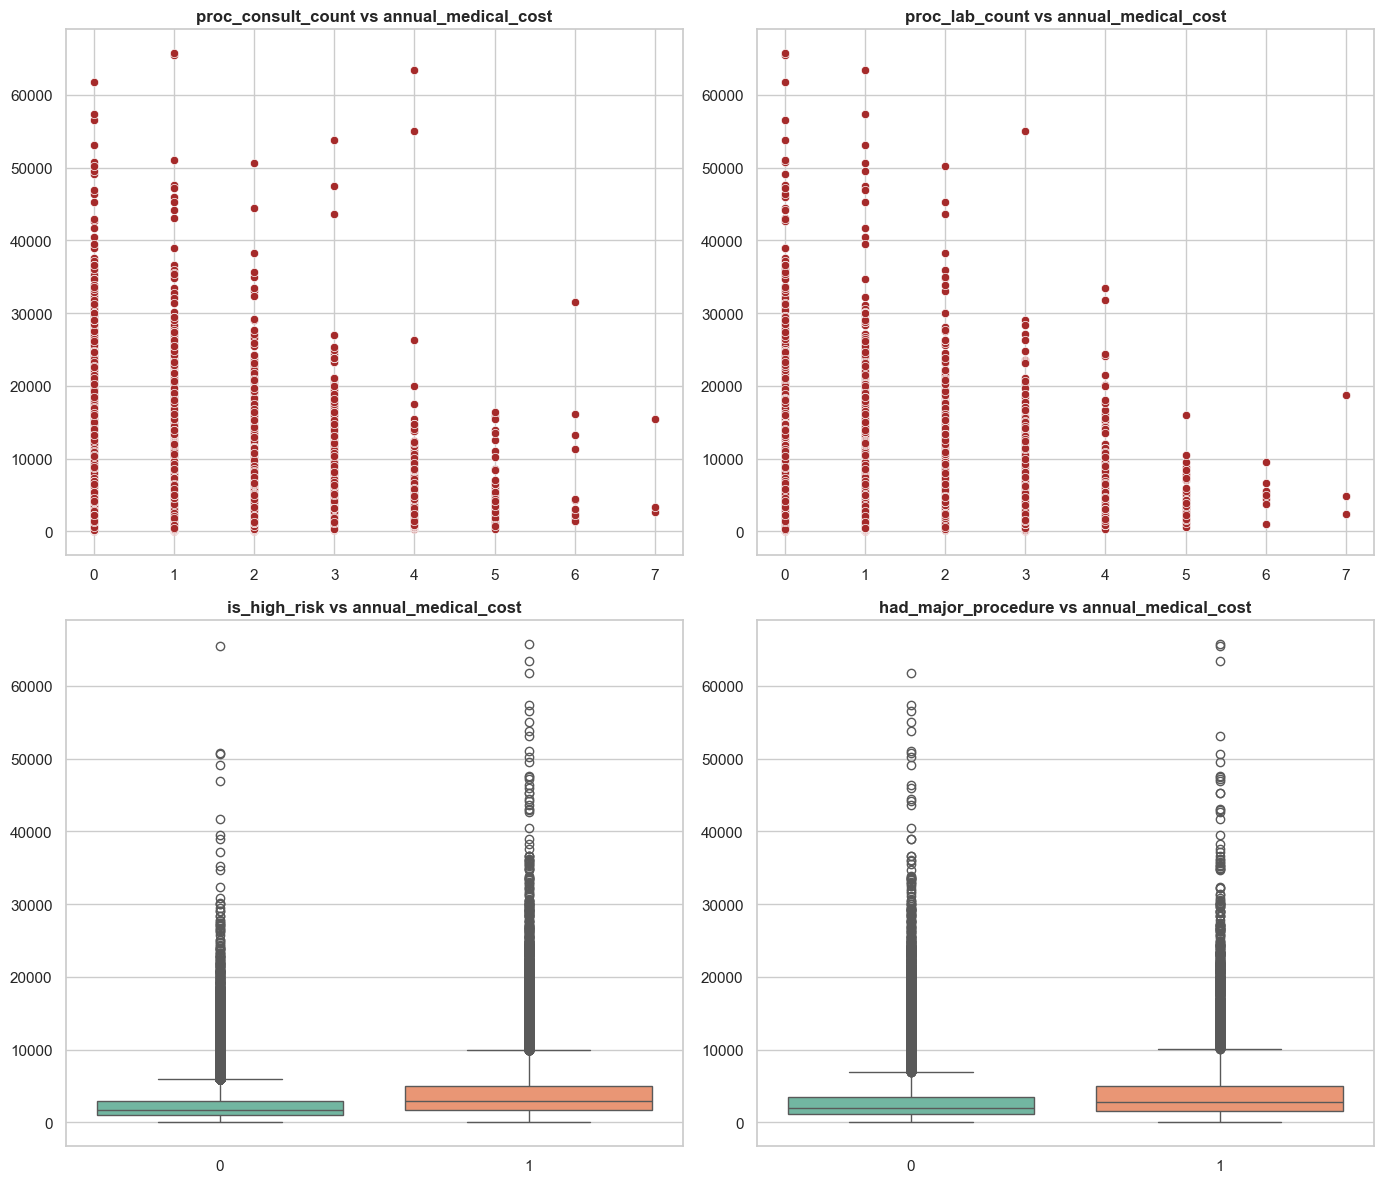

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

df = pd.read_csv('medical_insurance.csv')

columns = [
    "cancer_history", "kidney_disease", "liver_disease", "arthritis",
    "mental_health", "proc_imaging_count", "proc_surgery_count", 
    "proc_physio_count", "proc_consult_count", "proc_lab_count",
    "is_high_risk", "had_major_procedure"
]
target = "annual_medical_cost"

categorical_cols = ["cancer_history", "kidney_disease", "liver_disease", 
                    "arthritis", "mental_health", "is_high_risk", "had_major_procedure"]
numerical_cols = [col for col in columns if col not in categorical_cols]

def plot_batch(batch_cols, batch_number):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(batch_cols):
        ax = axes[i]
        if col in categorical_cols:
            sns.boxplot(x=col, y=target, data=df, ax=ax, palette="Set2", 
                       hue=col, dodge=False, legend=False)
        else:
            sns.scatterplot(x=col, y=target, data=df, ax=ax, color="brown")
        
        ax.set_title(f'{col} vs {target}', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

plot_batch(columns[0:4], 1)
plot_batch(columns[4:8], 2)
plot_batch(columns[8:12], 3)



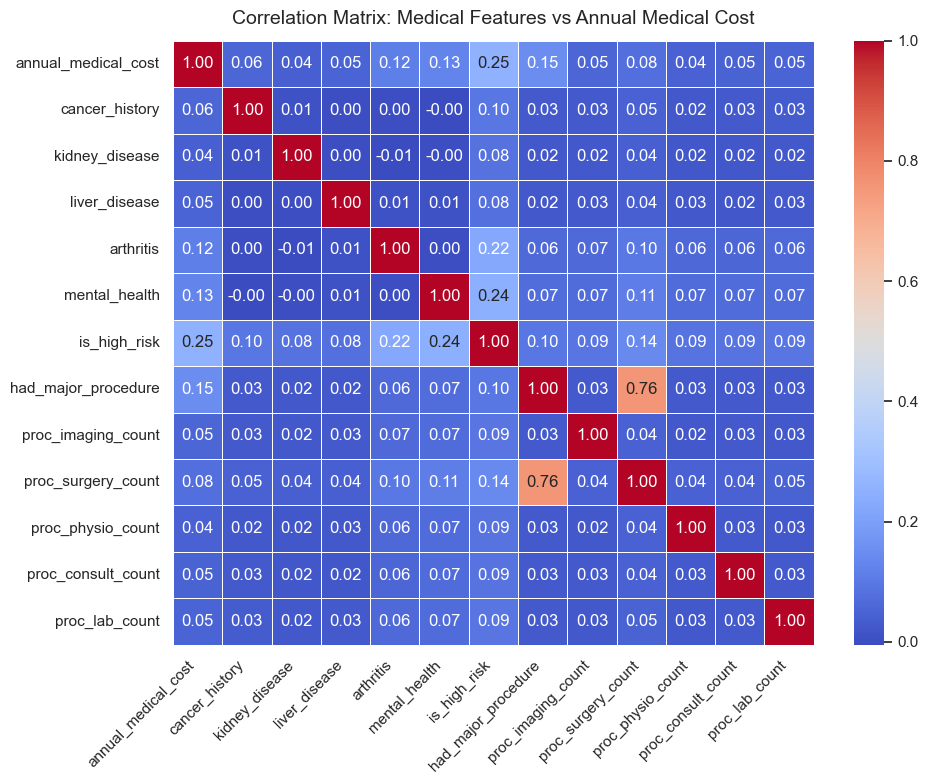

In [36]:
cols = [
    'annual_medical_cost', 'cancer_history', 'kidney_disease', 'liver_disease', 
    'arthritis', 'mental_health', 'is_high_risk', 'had_major_procedure',
    'proc_imaging_count', 'proc_surgery_count', 'proc_physio_count',
    'proc_consult_count', 'proc_lab_count'
]

corr = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Medical Features vs Annual Medical Cost', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [43]:

target_corr = corr['annual_medical_cost'].drop('annual_medical_cost').sort_values(ascending=False)

print("FEATURES BY CORRELATION WITH TARGET:")
for feature, corr_value in target_corr.items():
    print(f"{feature:25} : {corr_value:6.3f}")

relevant_features = target_corr[abs(target_corr) > 0.1].index.tolist()
print("\nFEATURES WITH |r| > 0.1:")
for feature in relevant_features:
    print(f"{feature:25} : {target_corr[feature]:6.3f}")

significant_features = []
for feature in cols[1:]:
    corr_coef, p_value = pearsonr(df[feature], df['annual_medical_cost'])
    if p_value < 0.05:
        significant_features.append((feature, corr_coef, p_value))

significant_features.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nSTATISTICALLY SIGNIFICANT FEATURES:")
for feat, corr_val, p_val in significant_features:
    print(f"{feat:25} | {corr_val:10.3f} | {p_val:8.4f}")

high_corr_pairs = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr.iloc[i, j]) > 0.7 and cols[i] != cols[j]:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))
#proc_surgery_count should be dropped high mu
print("\nHIGHLY CORRELATED FEATURE PAIRS:")
for feat1, feat2, corr_val in high_corr_pairs:
    print(f"{feat1:25} - {feat2:25} : {corr_val:.3f}")

X = df[cols[1:]]
y = df['annual_medical_cost']

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': cols[1:],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRANDOM FOREST FEATURE IMPORTANCE:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']:25} | {row['importance']:.4f}")

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'feature': cols[1:],
    'f_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('f_score', ascending=False)

print("\nF-TEST FEATURE SCORES:")
for _, row in feature_scores.iterrows():
    print(f"{row['feature']:25} | {row['f_score']:10.2f} | {row['p_value']:8.4f}")

feature_scores_summary = {}
for feature in cols[1:]:
    score = 0
    
    corr_val = abs(target_corr[feature])
    if corr_val > 0.2: score += 3
    elif corr_val > 0.1: score += 2
    elif corr_val > 0.05: score += 1
    
    p_val = feature_scores[feature_scores['feature'] == feature]['p_value'].values[0]
    if p_val < 0.001: score += 3
    elif p_val < 0.01: score += 2
    elif p_val < 0.05: score += 1
    
    rf_rank = feature_importance[feature_importance['feature'] == feature].index[0]
    if rf_rank < 3: score += 2
    elif rf_rank < 6: score += 1
    
    feature_scores_summary[feature] = score

final_scores = sorted(feature_scores_summary.items(), key=lambda x: x[1], reverse=True)

print("\nFINAL FEATURE RANKING:")
for i, (feature, score) in enumerate(final_scores, 1):
    if score >= 4:
        recommendation = "KEEP"
    elif score >= 2:
        recommendation = "KEEP" 
    else:
        recommendation = "DROP"
    print(f"{i:2} | {feature:25} | {score:2} | {recommendation}")

print("\nREDUNDANCY RESOLUTION:")
for feat1, feat2, corr_val in high_corr_pairs:
    corr1 = abs(target_corr[feat1])
    corr2 = abs(target_corr[feat2])
    if corr1 > corr2:
        keep, drop = feat1, feat2
    else:
        keep, drop = feat2, feat1
    print(f"KEEP: {keep:25} | DROP: {drop:25}")

final_features = [feat for feat, score in final_scores if score >= 2]
print(f"\nFINAL FEATURES TO KEEP ({len(final_features)}):")
for feature in final_features:
    print(f"  {feature}")


FEATURES BY CORRELATION WITH TARGET:
is_high_risk              :  0.252
had_major_procedure       :  0.148
mental_health             :  0.126
arthritis                 :  0.115
proc_surgery_count        :  0.077
cancer_history            :  0.055
proc_imaging_count        :  0.055
proc_lab_count            :  0.052
liver_disease             :  0.051
proc_consult_count        :  0.049
proc_physio_count         :  0.042
kidney_disease            :  0.042

FEATURES WITH |r| > 0.1:
is_high_risk              :  0.252
had_major_procedure       :  0.148
mental_health             :  0.126
arthritis                 :  0.115

STATISTICALLY SIGNIFICANT FEATURES:
is_high_risk              |      0.252 |   0.0000
had_major_procedure       |      0.148 |   0.0000
mental_health             |      0.126 |   0.0000
arthritis                 |      0.115 |   0.0000
cancer_history            |      0.055 |   0.0000
proc_imaging_count        |      0.055 |   0.0000
proc_lab_count            |      0.052 |

In [38]:
cols.remove("proc_surgery_count");


['annual_medical_cost', 'cancer_history', 'kidney_disease', 'liver_disease', 'arthritis', 'mental_health', 'is_high_risk', 'had_major_procedure', 'proc_imaging_count', 'proc_physio_count', 'proc_consult_count', 'proc_lab_count']
